# 2. Sampling, Fourier Transform, & Convolution

<ul>
    <li>2D Signals in Time & Frequency</li>
    <li>Spatial Sampling</li>
    <li>Discrete Fourier Transform</li>
    <li>Convolution</li>
</ul>  

In [2]:
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
from scipy import ndimage, misc, signal
# from scipy.stats import signaltonoise
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import numpy.fft
import timeit

In [3]:
import matplotlib 
print(matplotlib.__version__)

2.1.1


In [4]:
import skimage
print(skimage.__version__)

0.14.2


## Upsampling

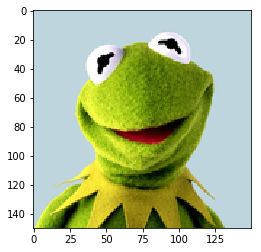

In [20]:
%matplotlib inline
img = Image.open('./img/kermit.jpg')
img_small = img.resize((img.width//2, img.height//2),
                                Image.ANTIALIAS)
plb.imshow(img_small)
img_small.save('./img/kermit_small.jpg')
plb.show()

In [21]:
def img_show(img):
    plb.figure(figsize=(10, 10))
    plb.imshow(img)
    plb.show()

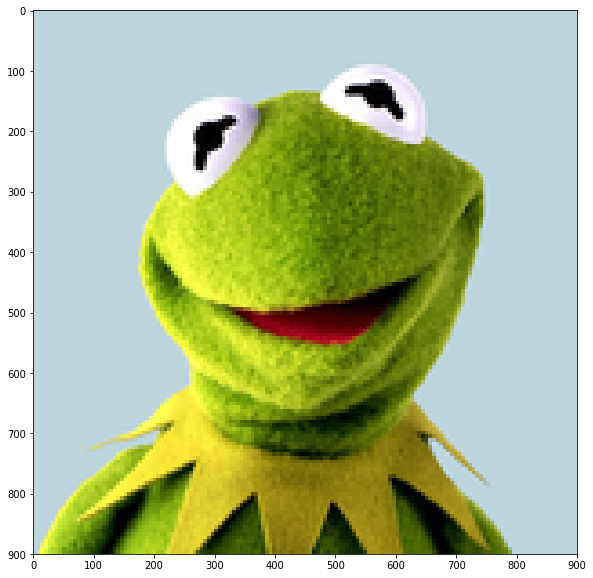

In [23]:
img1 = img_small.resize((img_small.width * 6, img_small.height * 6), Image.NEAREST)
img_show(img1)

So, some boxy edges here. We're wanting to show how fidelity is lost when we increase the size of an image, & though it's not super clear here, it is happening.

So to improve the quality, we'll perform some interpolation on the image. In <strong>bilinear</strong> interpolation, for each original pixel $P$, we have 4 neighbors $Q_{11}, Q_{12}, Q_{13}, and Q_{14}$. The intensity values of each neighbor is combined to compute the interpolated density at point $P$, as shown here:

$$f(x, y) = \frac{f(Q_{11})}{(x_2 - x_1)(y_2 - y_1)}(x_2 - x)(y_2 - y) + \frac{f(Q_{21})}{(x_2 - x_1)(y_2 - y_1)}(x_2 - x)(y_2 - y) + \frac{f(Q_{12})}{(x_2 - x_1)(y_2 - y_1)}(x_2 - x)(y_2 - y) + \frac{f(Q_{22})}{(x_2 - x_1)(y_2 - y_1)}(x_2 - x)(y_2 - y)$$

So let's try that with kermit:

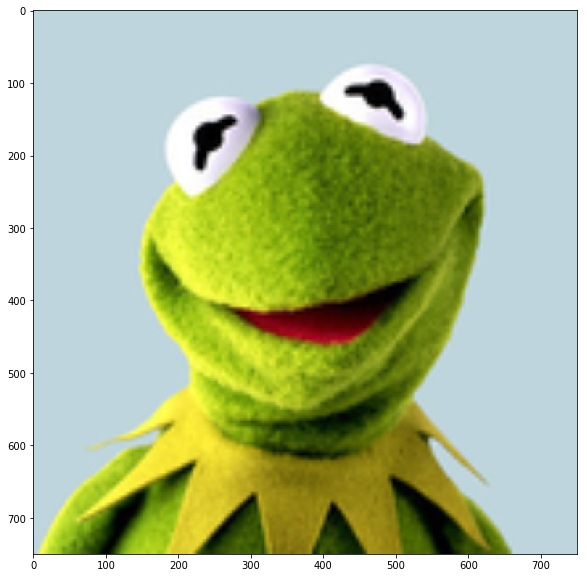

In [24]:
img1 = img_small.resize((img_small.width * 5, img_small.height * 5), Image.BILINEAR)
img_show(img1)

And bicubic:

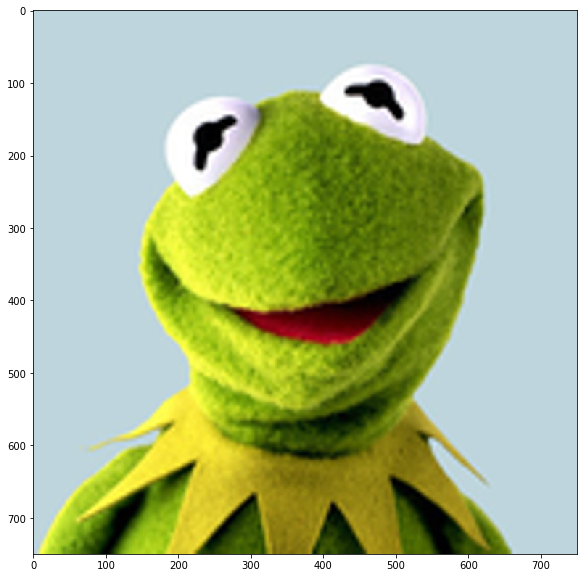

In [25]:
img1 = img_small.resize((img_small.width * 5, img_small.height * 5), Image.BICUBIC)
img_show(img1)

### Downscaling

Oddly enough, this also happens when we downscale an image: artifacts & such appear when downscaling due to a process known as <strong>aliasing</strong>. So, when we resize/rescale <em>down</em>, we want to use anti-aliasing to preserve image quality. Let's see Uli again:

/home/ben/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


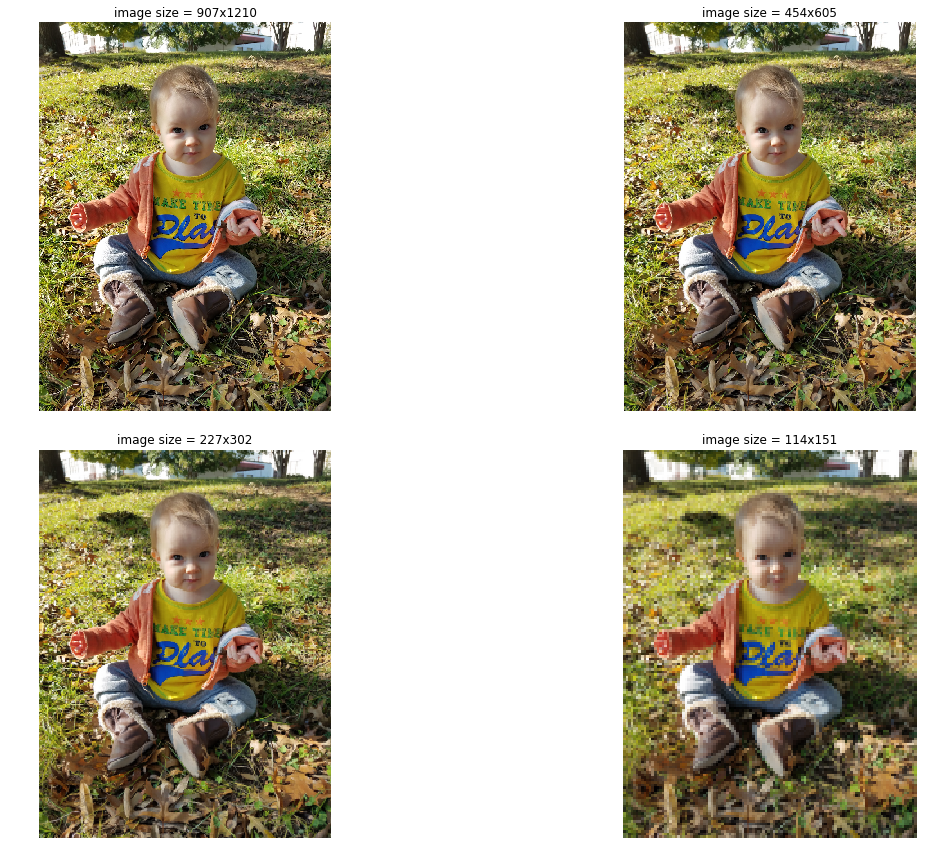

In [27]:
uli = imread('./img/Uli.jpg')
img1 = uli.copy()
plb.figure(figsize=(20, 15))
for i in range(4):
    plb.subplot(2, 2, i+1)
    plb.imshow(img1, cmap='gray')
    plb.axis('off')
    plb.title('image size = ' + str(img1.shape[1]) + 'x' + str(img1.shape[0]))
    img1 = rescale(img1, scale=0.5, multichannel=True, anti_aliasing=False)
plb.subplots_adjust(wspace=0.1, hspace=0.1)
plb.show()

Now, with antialiasing set to True:

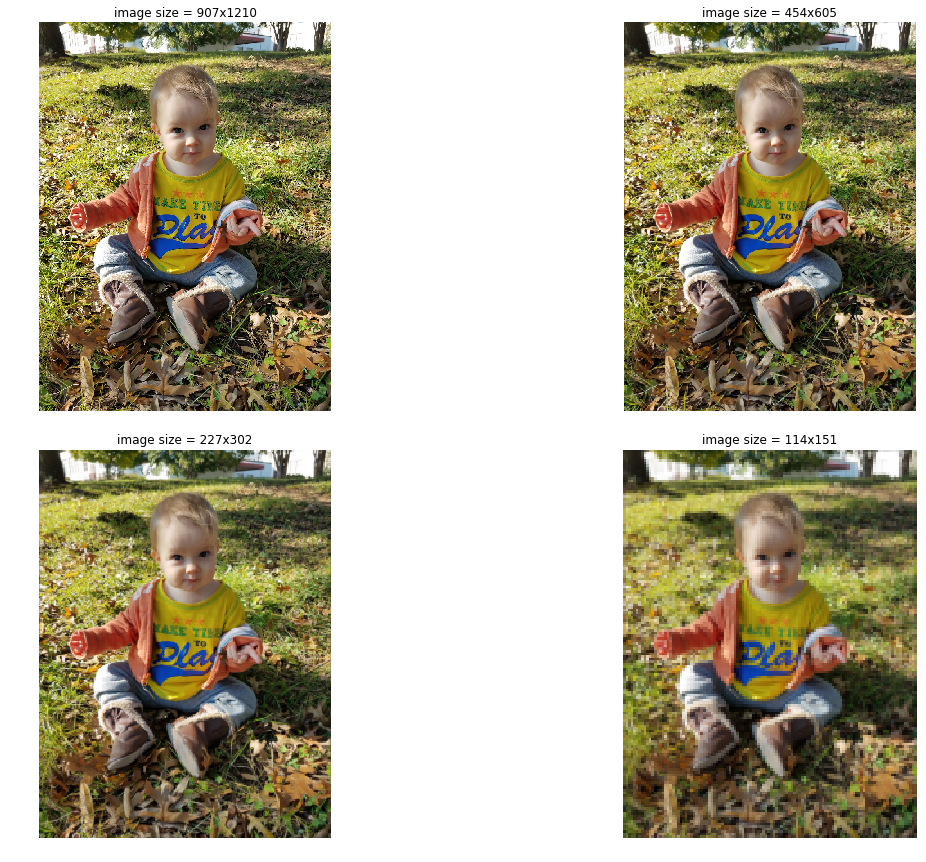

In [28]:
uli = imread('./img/Uli.jpg')
img1 = uli.copy()
plb.figure(figsize=(20, 15))
for i in range(4):
    plb.subplot(2, 2, i+1)
    plb.imshow(img1, cmap='gray')
    plb.axis('off')
    plb.title('image size = ' + str(img1.shape[1]) + 'x' + str(img1.shape[0]))
    img1 = rescale(img1, scale=0.5, multichannel=True, anti_aliasing=True)
plb.subplots_adjust(wspace=0.1, hspace=0.1)
plb.show()

## Quantization

We'll use Pillow to show this one. 

Quantization is related to the intensity of an image, & measured by bits per pixel. Usually we work with 8 bit values (0-255). If this intensity decreases, the quantization error increases, and we get artificial boundaries or contours.

This bit was the one using scipy's deprecated signaltonoise function, so we'll have to make our own:

In [29]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

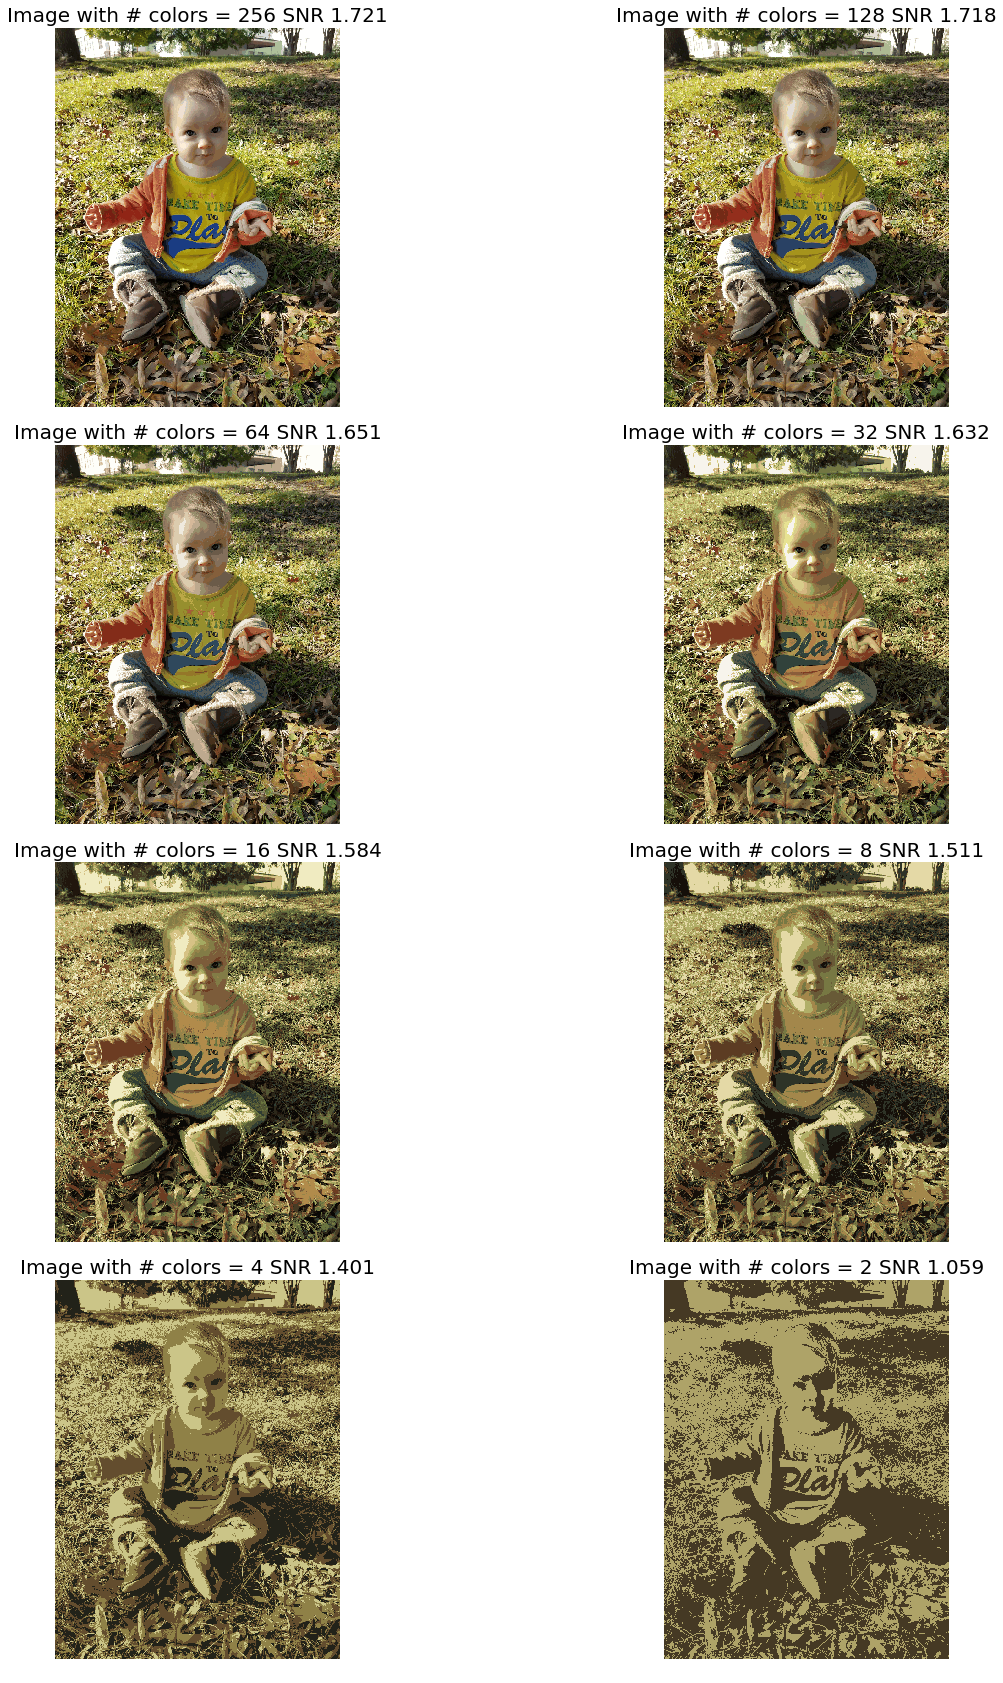

In [33]:
uli = Image.open('./img/Uli.jpg')
plb.figure(figsize=(20, 30))
num_colors_list = [1 << n for n in range(8, 0, -1)]
snr_list = []
i = 1
for num_colors in num_colors_list:
    img1 = uli.convert('P', palette=Image.ADAPTIVE, colors=num_colors)
    plb.subplot(4, 2, i)
    plb.imshow(img1)
    plb.axis('off')
    snr_list.append(signaltonoise(img1, axis=None))
    plb.title('Image with # colors = {0} SNR {1}'.format(num_colors, np.round(snr_list[i-1], 3)), size=20)
    i += 1
plb.subplots_adjust(wspace=0.2, hspace=0.1)
plb.show()

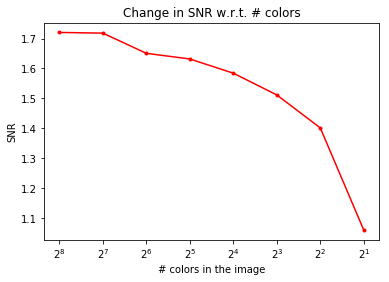

In [35]:
plb.plot(num_colors_list, snr_list, 'r.-')
plb.xlabel('# colors in the image')
plb.ylabel('SNR')
plb.title('Change in SNR w.r.t. # colors')
plb.xscale('log', basex=2)
plb.gca().invert_xaxis()
plb.show()

## Discrete Fourier Transform

This is a bit from digital signal processing, where the frequency (intensity in the frequency domain) is derived from data containing the intensity and time (in the time domain). In image processing, the useful part here is that it applies insofar as images are thought of as a 2D function that can be expressed as a weighted sum of sines and cosines along two dimensions. We'll use the pixel locations and pixel values as our inputs.

Where does it get us? Low-frequency values correspond to the average level of information in an image, while the high-frequency bits correspond to the first elements of more advanced processing: edges, corners, etc. In general, only a few coefficients in the DFT need to be used in order to reconstruct an image.

We'll first look at the <strong>Fast Fourier Transform (FFT)</strong>:

In [41]:
uli = np.array(Image.open('./img/Uli.jpg').convert('L'))
snr = signaltonoise(uli, axis=None)
print('SNR for the original image: ' + str(snr))

SNR for the original image: 1.751821955512916


In [42]:
freq = fp.fft2(uli)  # recall that fp is the scipy.fftpack module
img1 = fp.ifft2(freq).real  # inverse transform
snr = signaltonoise(img1, axis=None)
print('SNR for the original image: ' + str(snr))

SNR for the original image: 1.7518219555129162


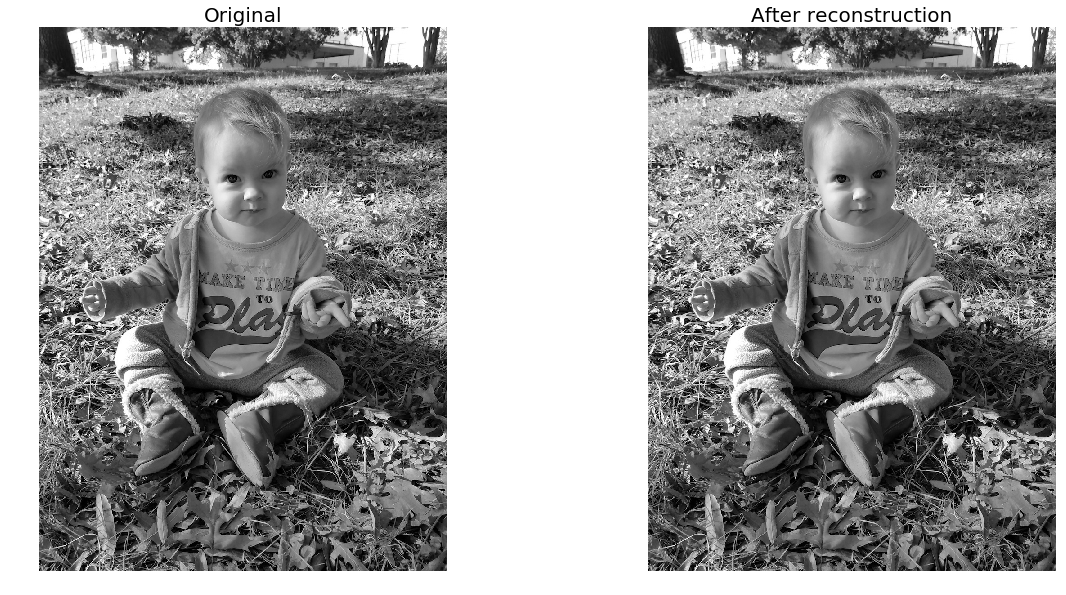

In [43]:
assert(np.allclose(uli, img1))
plb.figure(figsize=(20, 10))
plb.subplot(121)
plb.imshow(uli, cmap='gray')
plb.axis('off')
plb.title('Original', size=20)
plb.subplot(122), plb.imshow(img1, cmap='gray')
plb.axis('off')
plb.title('After reconstruction', size=20)
plb.show()

In [44]:
freq.shape

(1210, 907)

So now let's look at the transform image, even though we have yet to see why we're caring about this in the first place, other than my vague promises about applications:

/home/ben/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


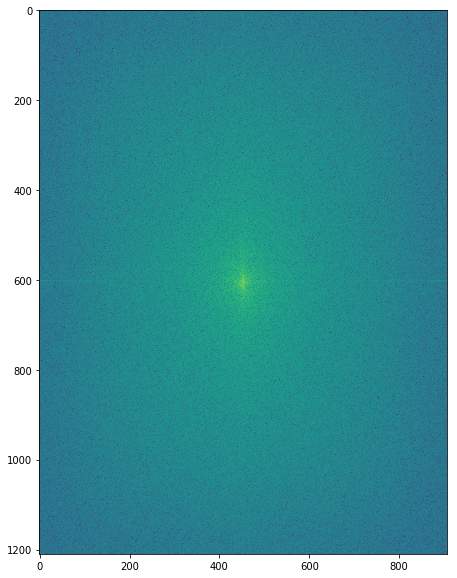

In [47]:
freq2 = fp.fftshift(freq)
plb.figure(figsize=(10, 10))
plb.imshow((20 * np.log10(0.1 + freq2)).astype(int))
plb.show()

...and with numpy:

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


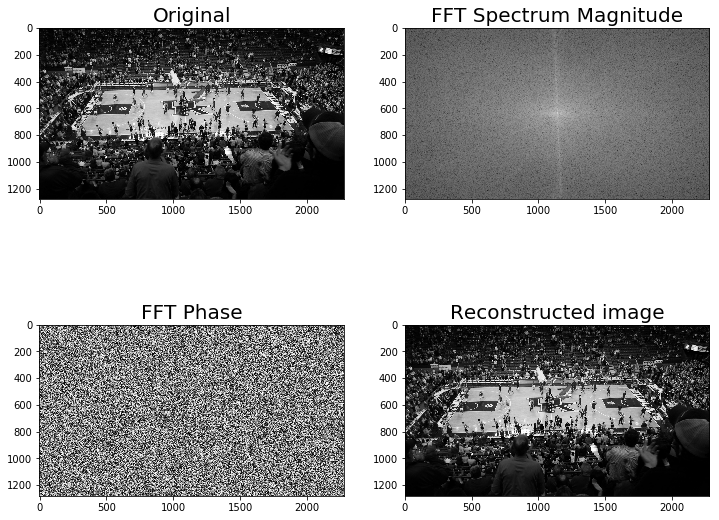

In [53]:
import numpy.fft as fp
img1 = rgb2gray(imread('./img/uk.jpg'))
plb.figure(figsize=(12, 10))
freq1 = fp.fft2(img1)
img1_ = fp.ifft2(freq1).real
plb.subplot(2, 2, 1)
plb.imshow(img1, cmap='gray')
plb.title('Original', size=20)
plb.subplot(2,2,2)
plb.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(freq1))), cmap='gray')
plb.title('FFT Spectrum Magnitude', size=20)
plb.subplot(2, 2, 3)
plb.subplot(2,2,3)
plb.imshow(np.angle(fp.fftshift(freq1)), cmap='gray')
plb.title('FFT Phase', size=20)
plb.subplot(2, 2, 4)
plb.imshow(np.clip(img1_, 0, 255), cmap='gray')
plb.title('Reconstructed image', size=20)
plb.show()

I'm not quite satisfied with my grasp of this yet, so I'll have to do some more digging.


## Understanding Convolution